# Installation instructions

1. Create virtual environment
    - virtualenv --system-site-packages -p python3 venv3
    - . ./venv3/bin/activate
2. Install kernels
    - cd kernels
    - ./build_all.sh
3. Install ipykernel
    - pip install --user ipykernel
    - python3 -m ipykernel install --user --name=varfloat
4. Select varfloat kernel
    - Kernel => Change Kernel => varfloat

In [1]:
import torch
import varfloat
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np

## Usage of varfloat

In [2]:
# Minifloat example 8 bit (1,4,3) - (sign, epxponent, fraction)
exp_bits = 4
fraction_bits = 3
round = True

# Saturation bounds depends on both eponent and fraction bits
bounds = varfloat.satBounds(exp_bits, fraction_bits)
print("min representable value: {}, max representable value: {}".format(bounds[0], bounds[1]))

x = torch.tensor([-110, 51.1, -1.1, 0.32, 90], dtype=torch.float).cuda()

# Scaling of tensor before converting to varfloat allows improve precision
sat_val = x.abs().max()
scale = sat_val / bounds[1]
print("scale: {:.5f}".format(scale))

# rescale x and conver to varfloat
y = varfloat.fromFloat(x / scale, exp_bits, fraction_bits, round) * scale
print(x.cpu())
print(y.cpu())

print("")
print("MSE with rescaling: {:.4}".format(torch.mean((y - x)**2)))
y = varfloat.fromFloat(x, exp_bits, fraction_bits, round)
print("MSE no rescaling: {:.4}".format(torch.mean((y - x)**2)))

min representable value: 0.0078125, max representable value: 480.0
scale: 0.22917
tensor([-110.0000,   51.1000,   -1.1000,    0.3200,   90.0000])
tensor([-110.0000,   51.3333,   -1.1458,    0.3151,   88.0000])

MSE with rescaling: 0.8113
MSE no rescaling: 1.762


## Minifloat on gaussian distribution

min representable value: 0.0078125, max representable value: 480.0
MSE: 0.0007197



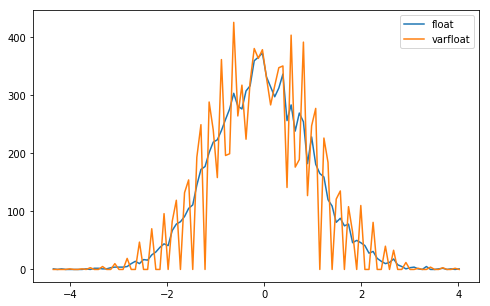

In [4]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Define minifloat
exp_bits = 4
fraction_bits = 3
round = True

# Saturation bounds depends on both eponent and fraction bits
bounds = varfloat.satBounds(exp_bits, fraction_bits)
print("min representable value: {}, max representable value: {}".format(bounds[0], bounds[1]))

x = torch.randn(10000).cuda()

# Conver to varfloat
y = varfloat.fromFloat(x, exp_bits, fraction_bits, round)

print("MSE: {:.4}\n".format(torch.mean((y - x)**2)))

rcParams['figure.figsize'] = 8, 5
hist1 = np.histogram(x.cpu(), bins=100)
plt.plot(hist1[1][:-1], hist1[0]);

hist2 = np.histogram(y.cpu(), bins=100, range=(x.min().item(), x.max().item()))
plt.plot(hist2[1][:-1], hist2[0]);
plt.legend(['float', 'varfloat']);

## Example of microfloat 4 bit (1,2,1) - (sign, epxponent, fraction)

min representable value: 0.5, max representable value: 6.0
scale: 0.72388
MSE: 0.02842

exp bit: 2, fraction bit: 1, saturation: 4.343


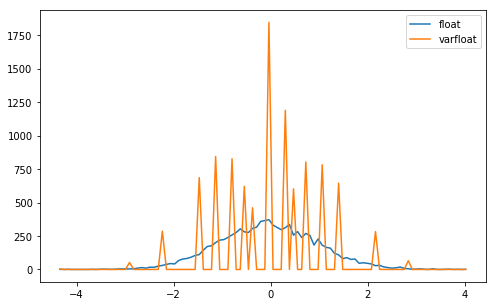

In [5]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Define microfloat
exp_bits = 2
fraction_bits = 1
round = True

# Saturation bounds depends on both eponent and fraction bits
bounds = varfloat.satBounds(exp_bits, fraction_bits)
print("min representable value: {}, max representable value: {}".format(bounds[0], bounds[1]))

x = torch.randn(10000).cuda()

# Rescale tensor to desirable range
sat_val = x.abs().max()
scale = sat_val / bounds[1]
print("scale: {:.5f}".format(scale))

# Conver to varfloat
y = varfloat.fromFloat(x / scale, exp_bits, fraction_bits, round) * scale

print("MSE: {:.4}\n".format(torch.mean((y - x)**2)))
print("exp bit: {}, fraction bit: {}, saturation: {:.3f}".format(exp_bits, fraction_bits, sat_val))

rcParams['figure.figsize'] = 8, 5
hist1 = np.histogram(x.cpu(), bins=100)
plt.plot(hist1[1][:-1], hist1[0]);

hist2 = np.histogram(y.cpu(), bins=100, range=(x.min().item(), x.max().item()))
plt.plot(hist2[1][:-1], hist2[0]);
plt.legend(['float', 'varfloat']);

## Use microfloat for havy tail distribution with arbitrary saturation

min representable value: 0.5, max representable value: 6.0

*** No saturation ***
scale: 16.71522
exp bit: 2, fraction bit: 1, max value: 100.291
MSE no saturation: 17.44

*** Saturation ***
scale: 9.33333
exp bit: 2, fraction bit: 1, max value: 56.000
MSE saturation: 6.602


(-201.9, 4239.9)

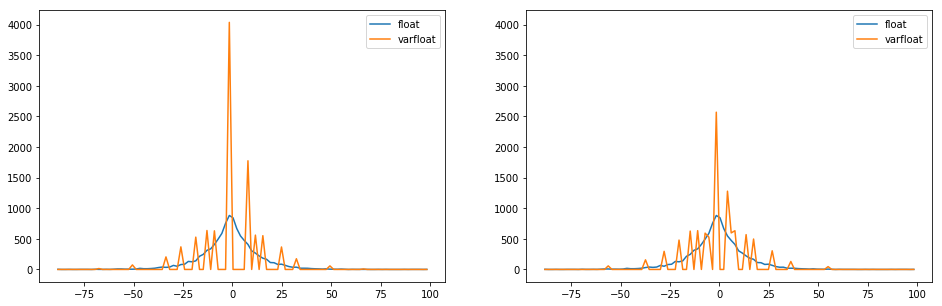

In [20]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Define microfloat
exp_bits = 2
fraction_bits = 1
round = True

# Saturation bounds depends on both eponent and fraction bits
bounds = varfloat.satBounds(exp_bits, fraction_bits)
print("min representable value: {}, max representable value: {}".format(bounds[0], bounds[1]))

x = torch.tensor(np.random.laplace(size=10000), dtype=torch.float).cuda() * 10

print("\n*** No saturation ***")
sat_val = x.abs().max()
scale = sat_val / bounds[1]
print("scale: {:.5f}".format(scale))

# rescale x and conver to varfloat
y = varfloat.fromFloat(x / scale, exp_bits, fraction_bits, round) * scale
print("exp bit: {}, fraction bit: {}, max value: {:.3f}".format(exp_bits, fraction_bits, sat_val))
print("MSE no saturation: {:.4}".format(torch.mean((y - x)**2)))

rcParams['figure.figsize'] = 16, 5
ax1 = plt.subplot(1, 2, 1)
histx = np.histogram(x.cpu(), bins=100)
ax1.plot(histx[1][:-1], histx[0]);

histy = np.histogram(y.cpu(), bins=100, range=(x.min().item(), x.max().item()))
ax1.plot(histy[1][:-1], histy[0]);

ax1.legend(['float', 'varfloat'])

print("\n*** Saturation ***")
ax2 = plt.subplot(1, 2, 2)
sat_val = 50
scale = sat_val / bounds[1]
print("scale: {:.5f}".format(scale))
print("exp bit: {}, fraction bit: {}, max value: {:.3f}".format(exp_bits, fraction_bits, sat_val))

# rescale x and conver to varfloat
y = varfloat.fromFloat(x / scale, exp_bits, fraction_bits, round) * scale
print("MSE saturation: {:.4}".format(torch.mean((y - x)**2)))

# histx = np.histogram(x.cpu(), bins=100)
ax2.plot(histx[1][:-1], histx[0]);

histy = np.histogram(y.cpu(), bins=100, range=(x.min().item(), x.max().item()))
ax2.plot(histy[1][:-1], histy[0]);

ax2.legend(['float', 'varfloat']);
ax2.set_ylim(ax1.get_ylim())